# Discrepancy Calculation and Generating Vector Searches
## for Kronecker and Extensible Lattice Sequences

This notebook demonstrates different uses and visualizations of Kronecker and Lattice sequences using the QMCPy software package.

Author: Jimmy Nguyen (nguyen.hoang.jimmy42@gmail.com)

In [1]:
import qmcpy as qp
import numpy as np
import timeit

import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import sympy as sy
import sympy.stats

from tqdm import tqdm # progress bar on loops, optional

In [2]:
# Currently, the images are untracked files.
save_figs = True
from pathlib import Path
import os

image_format = 'png'
# directories used to store images (for Overleaf organization purposes)
if save_figs:
    folders = ['samples', 'kronecker', 'lattice', 'both']
    for folder in folders:
        if not os.path.exists(folder):
            os.mkdir(folder)

In [3]:
plt.rcParams["figure.dpi"] = 300
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_samples(sampler, n, d_horizontal = 1, d_vertical = 2, marker_size = 5, figfac = 5, axis_pad = 0, font_family = "sans-serif"):
    plt.rcParams['font.family'] = font_family
    plt.rcParams['figure.constrained_layout.use'] = True

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    n = np.atleast_1d(n)
    samples = sampler.gen_samples(n[-1])    
    d = samples.shape[1]

    fig, ax = plt.subplots(ncols = n.size, figsize = (figfac, figfac * n.size), layout = "constrained")                  
     
    for i in range(n.size):
            ax[i].set_xlim([0 - axis_pad, 1 + axis_pad])
            ax[i].set_ylim([0 - axis_pad, 1 + axis_pad])

            ax[i].set_xticks([0, 1/4, 1/2, 3/4, 1])
            ax[i].set_yticks([0, 1/4, 1/2, 3/4, 1])

            ax[i].set_aspect(1)
            ax[i].grid(True)
                
            ax[i].set_xlabel('$x_{i1}$',fontsize = 15)
            ax[i].set_ylabel('$x_{i2}$',fontsize = 15)

            n_min = 0
            for m in range(i + 1): 
                n_max = n[m]
                ax[i].scatter(samples[n_min:n_max, 0], samples[n_min:n_max, 1], s = marker_size, color = colors[m])
                n_min = n[m]

    return fig, ax

def save_figure(path, fig):
    if save_figs:
        fig.savefig(Path(f'{path}.' + image_format), format = image_format)

In [4]:
dimension = 6 
axis_pad = 0.05
marker_size = 15
fig_factor = 10

## IID Sequences

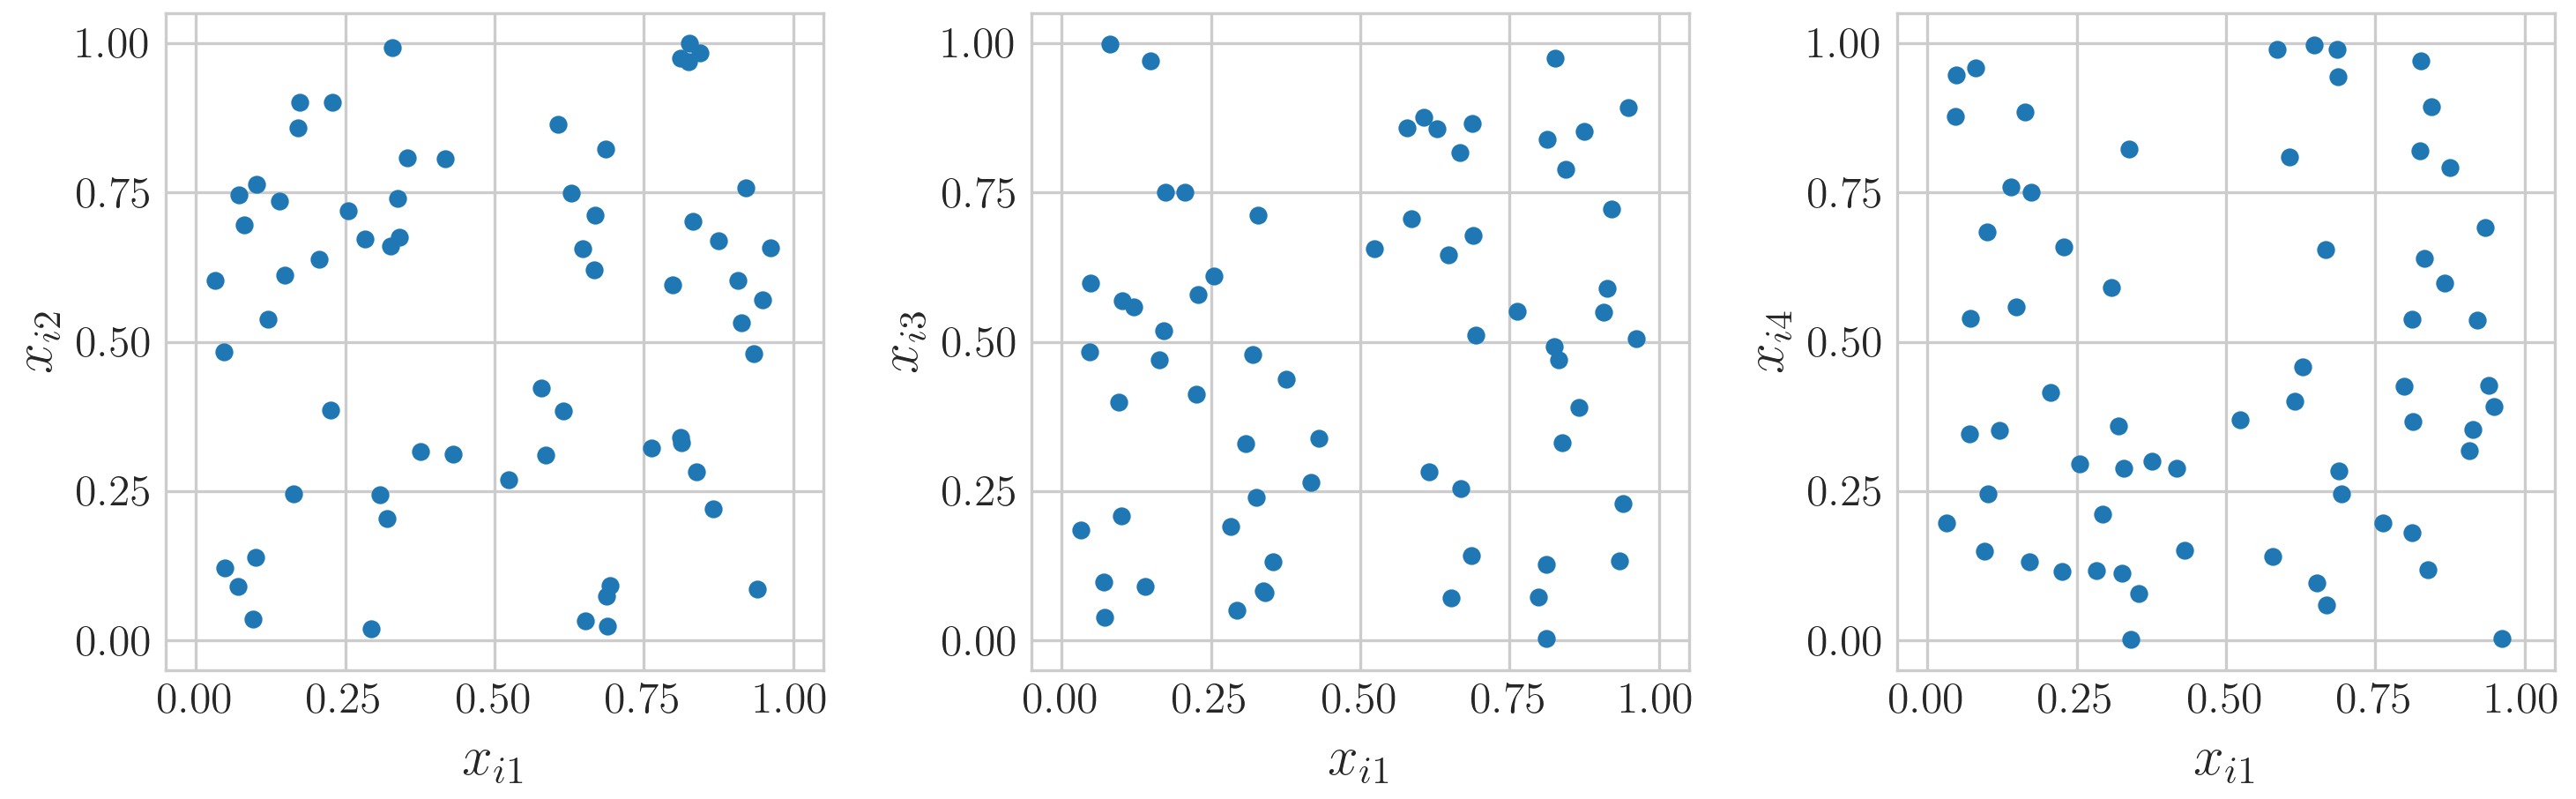

In [5]:
fig, ax = qp.plot_proj(qp.IIDStdUniform(dimension, seed = 24), d_horizontal = np.array([1]), d_vertical = np.arange(2, 5),
                       figfac = fig_factor, axis_pad = axis_pad, marker_size = marker_size, fig_title = '')
save_figure('samples/iid', fig)

# Samples of Low Discrepancy Sequences
## Kronecker Sequences

In [6]:
n_list = [32, 64, 90]

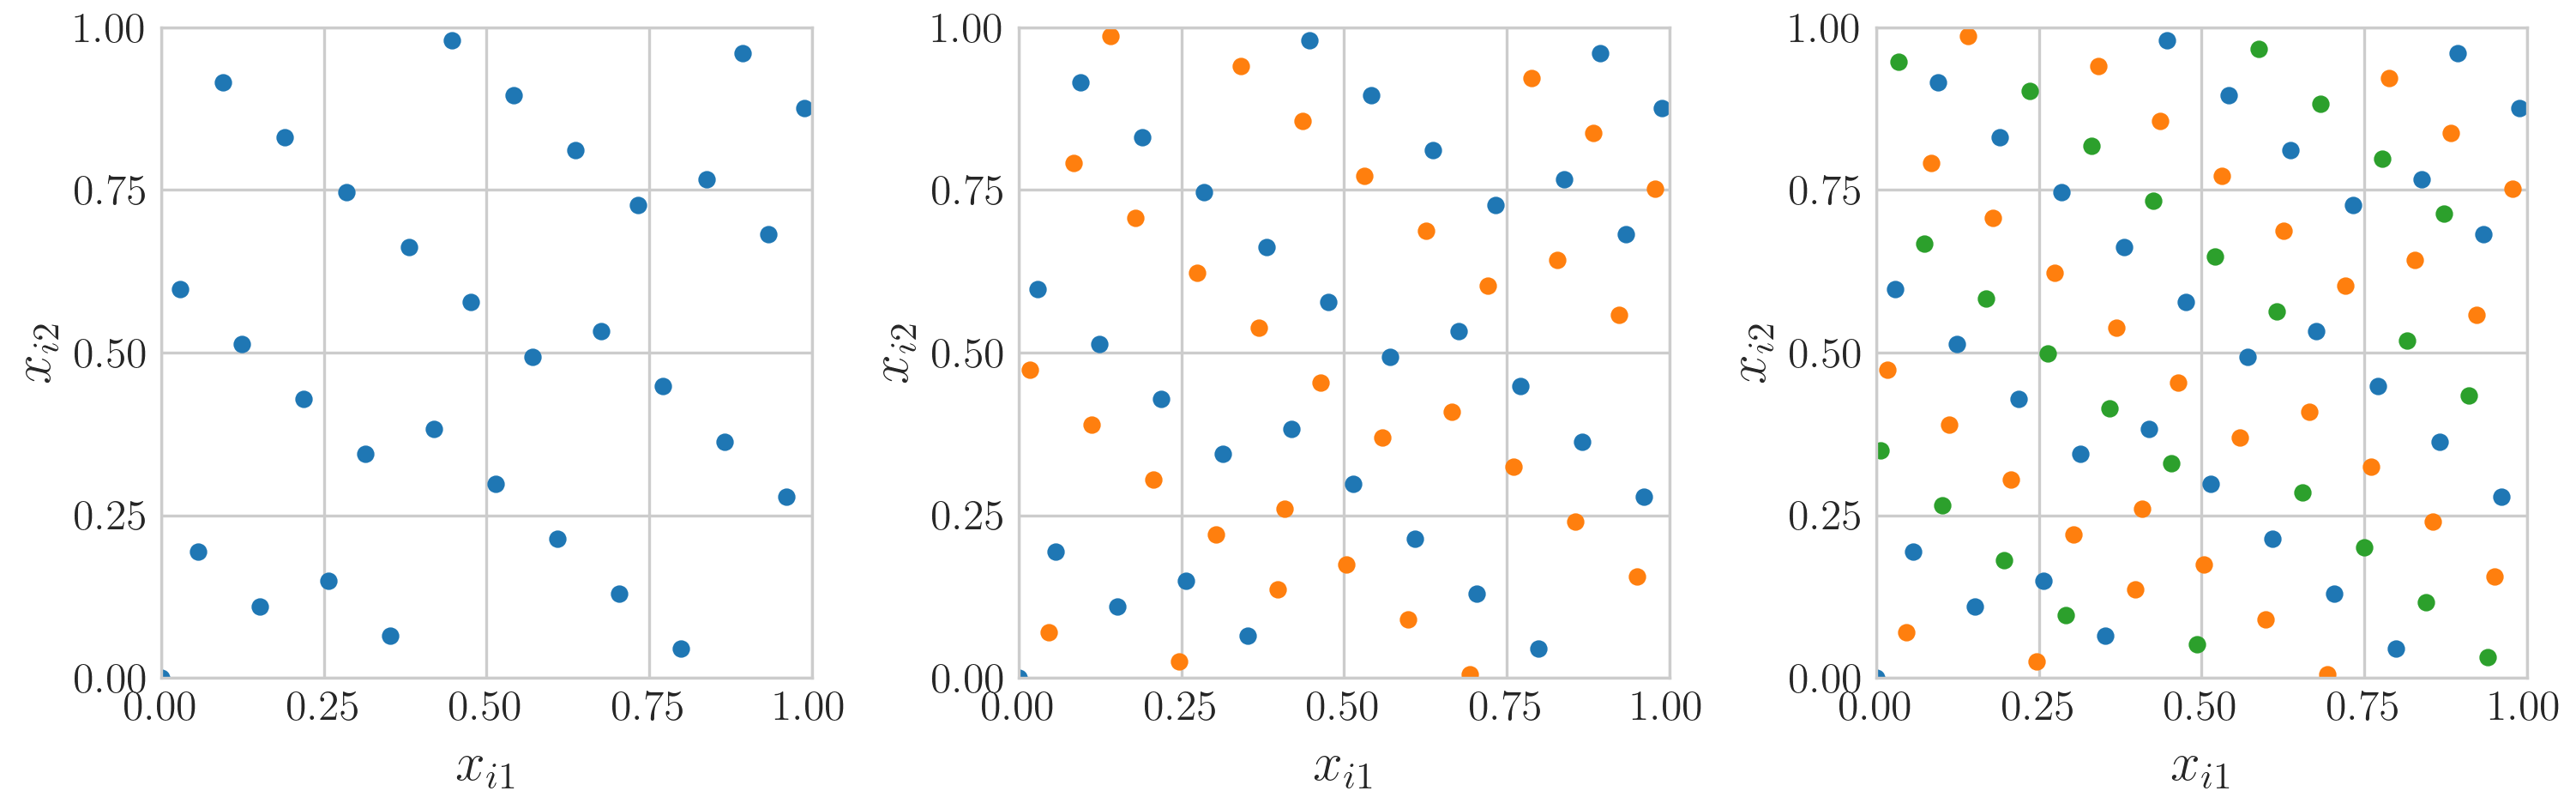

In [7]:
alpha = np.array([0.41900501, 0.38310311, 0.10865909, 0.24084945, 0.17683976, 0.26454], dtype=np.float64)
fig, ax = plot_samples(qp.Kronecker(dimension, alpha), n_list, marker_size = marker_size, figfac = fig_factor)
save_figure('samples/kronecker', fig)

## Lattice Sequences

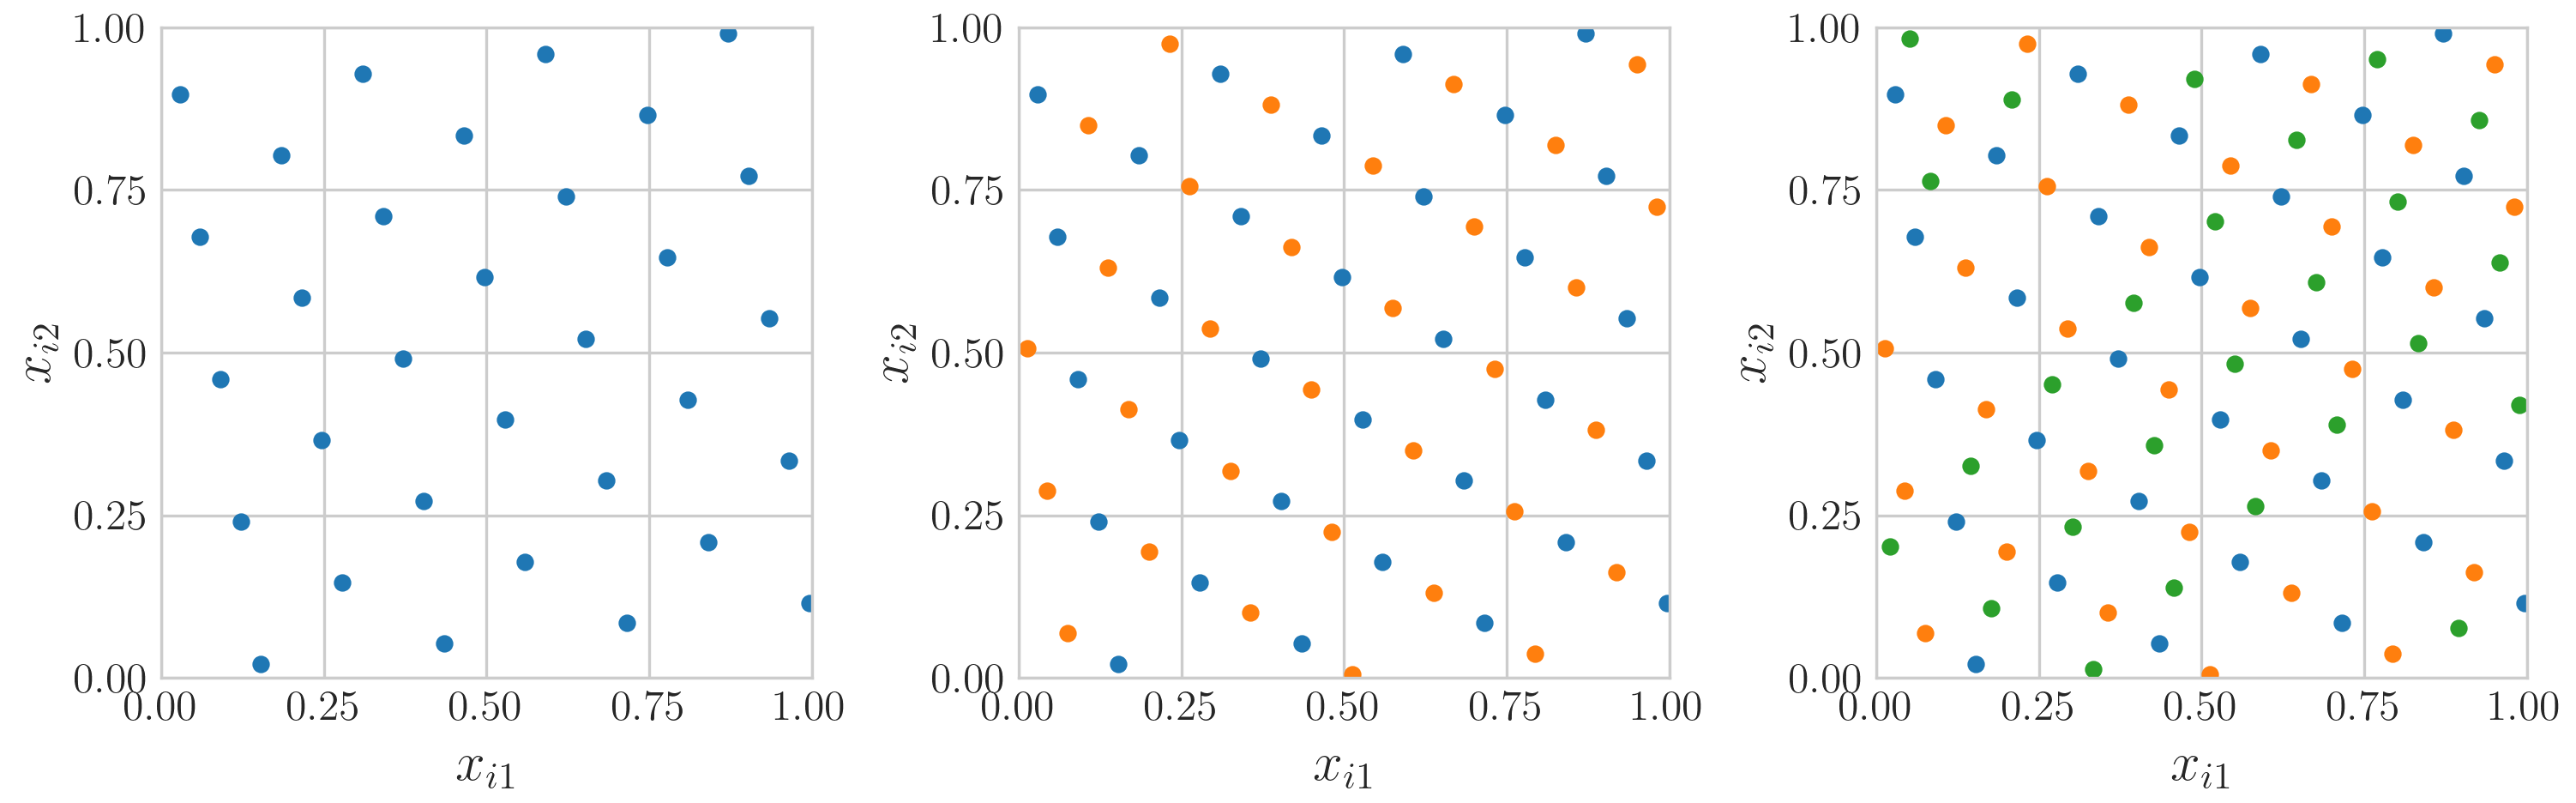

In [8]:
generating_vector = np.array([1, 444633, 468443, 63389, 310317, 297749], dtype=np.uint64)
fig, ax = plot_samples(qp.Lattice(dimension, generating_vector = generating_vector, order = 'gray', d_max=6, m_max=2**20),
                       n_list, marker_size = marker_size, figfac = fig_factor)
save_figure('samples/lattice', fig)

# Comparisons to Other Generating Vectors


In [9]:
dimensions = np.array([5, 50])

## Kronecker: CBC and Richtmyer

In [10]:
# creates a d-length np.array with values 1/l^2
def calculate_gamma(dimension):
    return 1 / (np.arange(1, dimension + 1) ** 2)

def plot_discrepancy(dimension, alpha, n=1e6, gamma=None, trend=True, title=None):
    kronecker = qp.Kronecker(dimension=dimension, alpha=alpha)

    if gamma is None:
        values = kronecker.periodic_discrepancy(int(n))
    else:
        values = kronecker.periodic_discrepancy(int(n), gamma=gamma)

    x = np.arange(1, int(n) + 1)
    y = values[0] / x # multiply by values[0] to get the same starting point
    y_half = values[0] / np.sqrt(x)
    if trend:
        plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
        plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')

    plt.loglog(x, values, label="Kronecker")
    
    if title is not None:
        plt.title(title)
        
    plt.xlabel('Number of sample points')
    plt.ylabel('Discrepancy')
    plt.legend()
    plt.show()

We compare the CBC searched $\alpha$ to $\alpha_{\mathrm{Richt}}:= (\sqrt{p_1} \bmod 1, \sqrt{p_2} \bmod1, \dots),$ where $p_{\ell}$ is the $\ell$ th prime.


In [11]:
gamma = [calculate_gamma(dimension) for dimension in dimensions] # coordinate weights

## Lattice: New CBC and Kuo et al.

We compare our CBC searched generating vector to the one found by Kuo et al.

# Decay Comparisons

We calculate the convergence rate of discrepancy per dimension using a weighted linear regression for both Kronecker and Lattice sequences.

In [12]:
def square_discrepancy(k_tilde_terms, n_array, n):
    left_sum = np.cumsum(k_tilde_terms[1:]) * n_array[1:]
    right_sum = np.cumsum(n_array[:-1] * k_tilde_terms[1:])

    k_tilde_zero_terms = k_tilde_terms[0] * n_array
    summation = np.zeros(n)
    summation[1:] = left_sum - right_sum
    return (k_tilde_zero_terms + 2 * summation) / (n_array ** 2) - 1

# calculates the decay rate for dimensions 2, ..., d
def calculate_decay(dimension, alpha, gamma, n, x):
    decays = np.empty(dimension)

    n = int(n)
    n_array = np.arange(1, n + 1)

    kronecker = qp.Kronecker(dimension = dimension, alpha = alpha)
    samples = kronecker.gen_samples(n)

    previous_k_tilde = 1
    for d in range(1, dimension + 1):
        k_tilde = (1 + (samples[:, d - 1] * (samples[:, d - 1] - 1) + 1/6) * gamma[d - 1]) * previous_k_tilde
        previous_k_tilde = k_tilde

        discrepancies = np.sqrt(square_discrepancy(k_tilde, n_array, n))
        decays[d - 1] = np.polyfit(np.log(x), np.log(discrepancies), 1, w = 1 / (np.arange(1, int(n) + 1)))[0]

    return decays[1:]

In [13]:
dimension = 1000

gamma = calculate_gamma(dimension)
dimensions = range(2, dimension + 1)

n = 2 ** 17
x = np.arange(1, int(n) + 1)

richtmyer_rates = np.empty(len(dimensions))
cbc_rates = np.empty(len(dimensions))

In [14]:
# Generating Vectors

d1000_alpha = np.loadtxt(Path('kron_vector/d1000_n1e5_1e4alpha.txt'))
# new_decay = np.genfromtxt('2exp17_500dim_new_lattice_decay_data.csv', delimiter=',', dtype=float)
# kuo_decay = np.genfromtxt('2exp17_500dim_qmcpy_lattice_decay_data.csv', delimiter=',', dtype=float)

In [15]:
# Decay Calculations
richtmyer_rates = calculate_decay(dimension, 'richtmyer', gamma, n, x)
cbc_rates = calculate_decay(dimension, d1000_alpha, gamma, n, x)

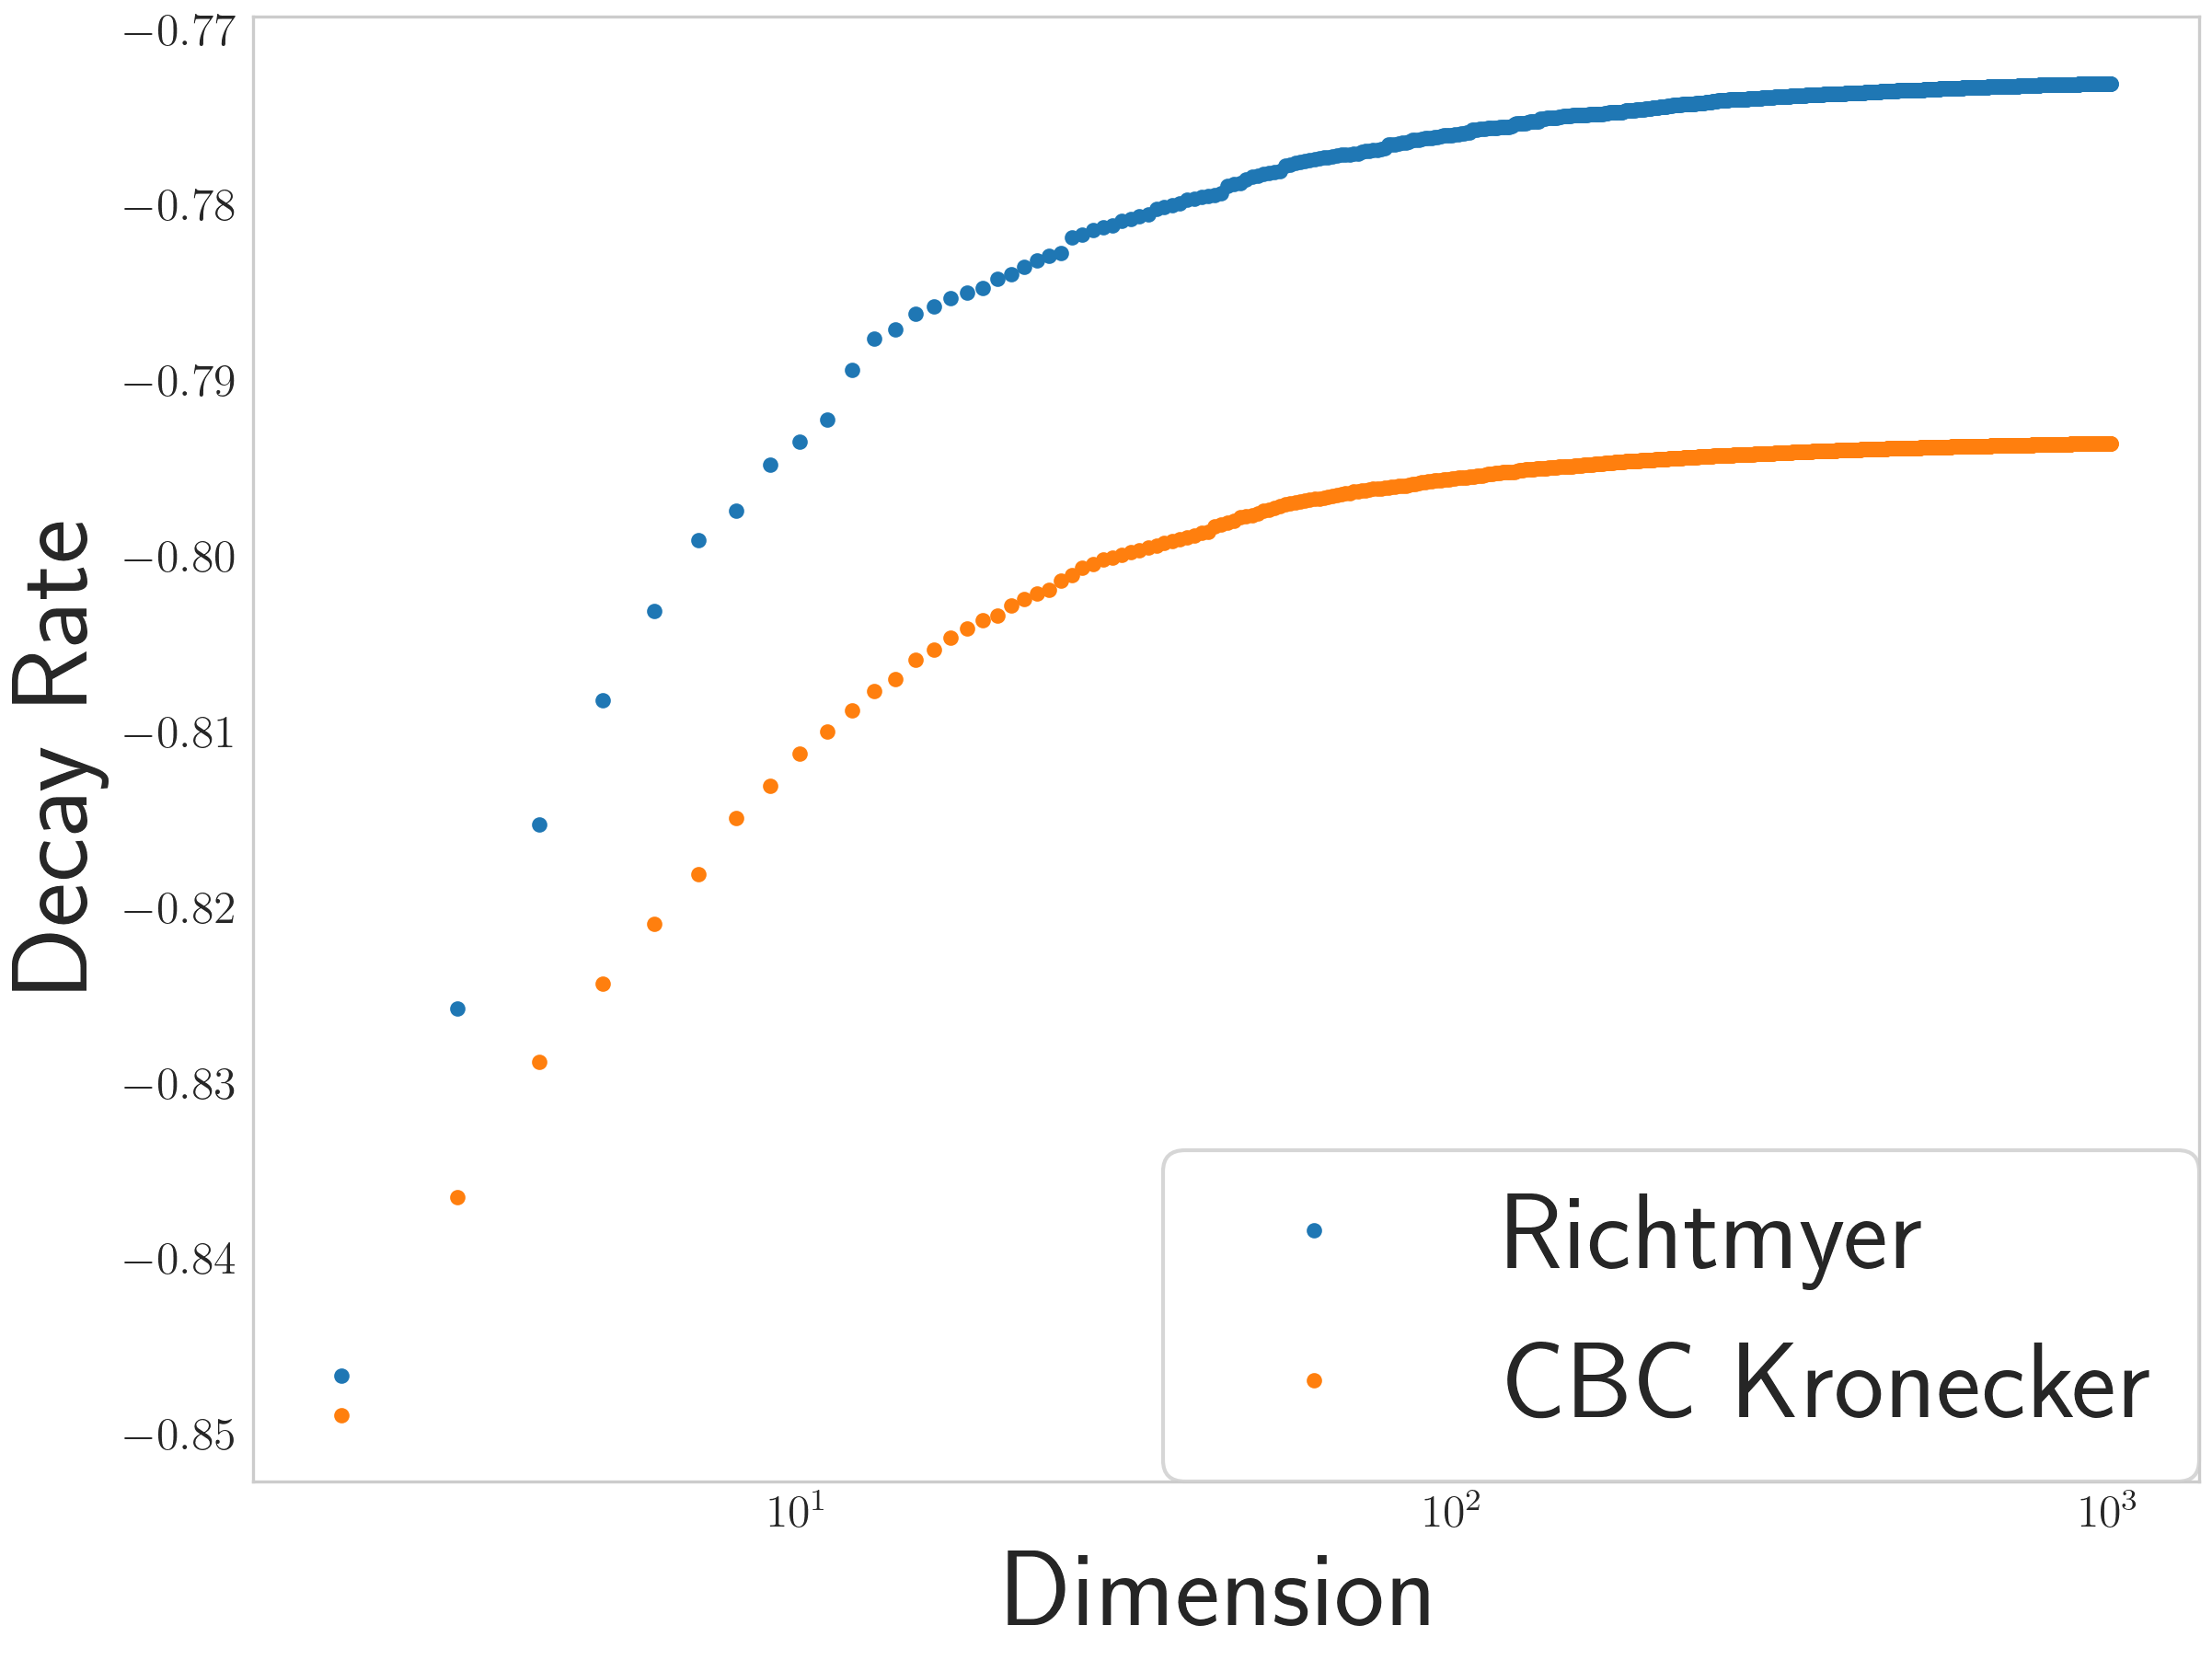

In [16]:
# sequences = ['Richtmyer', 'CBC Kronecker', 'Lattice (new)', 'Lattice (Kuo)']
rates = [richtmyer_rates, cbc_rates]
sequences = ['Richtmyer', 'CBC Kronecker']
fig, ax = plt.subplots(layout = "constrained")
ax.grid(False)
for i, name in enumerate(sequences):
    ax.semilogx(dimensions, rates[i], '.', label = name, color = colors[i])

# plt.semilogx(dimensions, new_decay[:max(dimensions) - 1], '.', label='Lattice (new)', color=color3)
# plt.semilogx(dimensions, qmc_decay[:max(dimensions) - 1], '.', label='Lattice (QMCPy)', color=color4)

fontsize = 28
ax.set_xlabel('Dimension', fontsize = fontsize)
ax.set_ylabel('Decay Rate', fontsize = fontsize)
ax.legend(loc = 'lower right', frameon = True, fontsize = fontsize)

save_figure('both/decay', fig)